<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/VAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vector AutoRegressive Models
![](https://resources.premierleague.com/photos/2019/11/14/615df1b3-77ae-40c2-82af-45cd5b398697/VAR-big-screen-Man-City-cropped.jpg?width=930&height=620)

# Install

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import scipy.stats as stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

from statsmodels.tools.eval_measures import rmse, aic

# Data

In [3]:
macro_df = sm.datasets.macrodata.load_pandas().data
macro_df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [4]:
macro_df.index = pd.to_datetime(macro_df.year.astype(int).astype(str) + 
                         '-Q' + macro_df.quarter.astype(int).astype(str))
macro_df = macro_df.drop(columns=['year', 'quarter'])
macro_df = macro_df.asfreq('QS')

# Intuition
* We use VAR when multiple timeseries influence eachother
* The time series variables are modeled as functions of past values (i.e. lags)
* Time series in the model influence eachother rather than a single outcome value

![](http://what-when-how.com/wp-content/uploads/2011/04/tmpC44_thumb.png)

# Exploratory

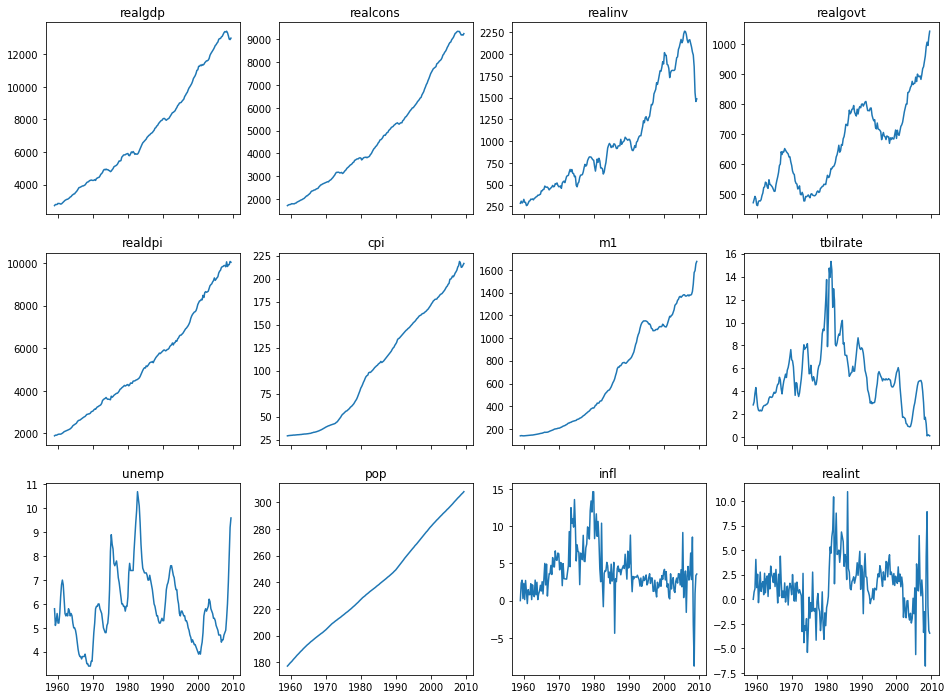

In [5]:
fig, ax = plt.subplots(3, 4, figsize=(16,12), sharex=True)
pos = np.array(macro_df.columns).reshape(3, 4)
for row in range(pos.shape[0]):
  for col in range(pos.shape[1]):
    ax[row][col].plot(macro_df[pos[row][col]])
    ax[row][col].set_title(pos[row][col])

# Granger's Causality Test
* A statistical test
  * Null Hypothesis - Coefficients of past values are zero
  * In plain speak - The past values of one time series do not have a causal effect on another time series
* To apply this, we test combinations of two series
  * We look at most "n" lags
  * Compare p-values

In [6]:
def granger_test(df, max_lags=3):
  results_df = pd.DataFrame(columns=df.columns)
  for row in df.columns:
    for col in df.columns:
      test = grangercausalitytests(df[[row, col]], maxlag=max_lags, verbose=False)
      p_value = min([test[i + 1][0]['ssr_chi2test'][1] for i in range(max_lags)])
      results_df.loc[row, col] = round(p_value, 4) 
  return results_df

granger_df = granger_test(macro_df)
granger_df

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
realgdp,1.0,0.0,0.0925,0.0227,0.0216,0.0846,0.0041,0.0026,0.0067,0.0194,0.0136,0.1038
realcons,0.0095,1.0,0.0002,0.0265,0.0115,0.0,0.0277,0.0031,0.2335,0.0034,0.0,0.0006
realinv,0.0,0.0,1.0,0.0344,0.0011,0.0001,0.0002,0.0,0.0001,0.1951,0.0,0.0004
realgovt,0.0249,0.0487,0.0088,1.0,0.0695,0.1144,0.6291,0.853,0.2136,0.0006,0.3896,0.2041
realdpi,0.0003,0.0,0.0468,0.1553,1.0,0.0015,0.241,0.2852,0.0517,0.0099,0.0015,0.0023
cpi,0.3609,0.0009,0.2778,0.071,0.0099,1.0,0.016,0.0,0.2459,0.0015,0.0,0.0062
m1,0.0025,0.0001,0.0043,0.0,0.0,0.0003,1.0,0.1452,0.0,0.0299,0.3226,0.171
tbilrate,0.0134,0.0376,0.0171,0.0592,0.0985,0.0766,0.1146,1.0,0.02,0.1302,0.0201,0.0184
unemp,0.0,0.0,0.1494,0.1249,0.091,0.1829,0.2209,0.0039,1.0,0.1617,0.0058,0.5337
pop,0.1384,0.6113,0.7929,0.0004,0.6503,0.0,0.0,0.0001,0.069,1.0,0.0018,0.755


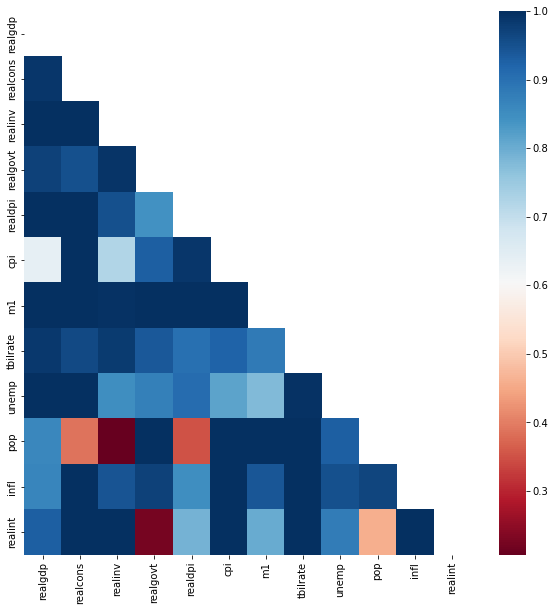

In [75]:
# 1 - p-value (higher values are more significant -- in dark blue)
granger_lt = granger_df.where(np.tril(np.ones(granger_df.shape), k=-1).astype(bool))
plt.figure(figsize=(10,10))
hmap = sns.heatmap(1.0 - granger_lt.astype(float), cmap='RdBu')

# CoIntegration Test
* Used to find correlation in non-stationary time series (in long term) 
  * Order of integration - how many differences to make a time series stationary
  * If there's a linear combination of the series that requires fewer differences than the individual series, they are cointegrated
* Function takes
  * Dataset
  * Determination (-1 = None, 0 = Constant, 1 = Linear)
  * Lags to test
* Other tests
  * Engle-Grander
  * Phillips-Ouliaris

In [8]:
def cointegration_test(df, alpha=0.05): 
  result = coint_johansen(df, -1, 5)
  d = {'0.90': 0, '0.95': 1, '0.99': 2}
  traces = result.lr1 # Trace Statistic
  cvs = result.cvt[:, d[str(1 - alpha)]] # Critical Values
    
  results_df = pd.DataFrame(columns=['Trace Statistic', 'Critical Value', 'Significant'])
  for column, trace, cv in zip(df.columns, traces, cvs):
    results_df.loc[column] = [round(trace, 2), cv, trace > cv]
  return results_df

cointegration_test(macro_df)

,Trace Statistic,Critical Value,Significant
realgdp,565.18,311.1288,True
realcons,444.42,263.2603,True
realinv,358.27,219.4051,True
realgovt,275.07,179.5199,True
realdpi,205.37,143.6691,True
cpi,157.57,111.7797,True
m1,115.95,83.9383,True
tbilrate,77.44,60.0627,True
unemp,49.22,40.1749,True
pop,28.25,24.2761,True


# Stationary
* Explore the number of differences to make each time series stationary

In [9]:
def adfuller_test(df, significance=0.05, differences=2):
  results_df = pd.DataFrame(index=df.columns)
  test_df = df.copy()

  for diff in range(differences + 1):
    results = []
    for col in test_df.columns:
      test = adfuller(test_df[col], autolag='AIC')  
      p_value = test[1]
      results.append(p_value < significance)
    results_df[f'diff-{diff}'] = results
    test_df = test_df.diff().dropna()
  
  return results_df

adfuller_test(macro_df, differences=2)

,diff-0,diff-1,diff-2
realgdp,False,True,True
realcons,False,True,True
realinv,False,True,True
realgovt,False,True,True
realdpi,False,True,True
cpi,False,False,True
m1,False,True,True
tbilrate,False,True,True
unemp,False,True,True
pop,False,False,True


# Preprocessing
* Identify columns 
* Train test split (12 periods ~ 3 years)

In [22]:
COLUMNS = ['unemp', 'infl', 'realgovt']
SPLIT = -12

In [23]:
# Difference the data & Split into train / test
macro_diffed_df = macro_df[COLUMNS].diff(1).dropna()
train_df = macro_diffed_df[: SPLIT]
test_df = macro_diffed_df[SPLIT : ]

# Optimal P
* Compare AIC (or BIC)
* FPE - Final Prediction Error
* HQIC - Hannan Quinn Information Criteria

In [24]:
# Inspect unemployment, inflation and govt spending
var = VAR(train_df)
selector = var.select_order(maxlags=12)
selector.summary()

,AIC,BIC,FPE,HQIC
0,4.579,4.633,97.42,4.601
1,3.806,4.021,44.99,3.893
2,3.602,3.977*,36.66,3.754*
3,3.592,4.128,36.31,3.809
4,3.547*,4.244,34.73*,3.829
5,3.601,4.459,36.70,3.949
6,3.652,4.671,38.66,4.066
7,3.653,4.833,38.74,4.131
8,3.680,5.021,39.86,4.224
9,3.696,5.198,40.61,4.305


# Model
* Pick the order associated with lowest AIC
* Linear Regressions!

## Fit

In [25]:
var = VAR(train_df)
model = var.fit(4)
model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jun, 2022
Time:                     18:30:44
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.23421
Nobs:                     186.000    HQIC:                   3.83194
Log likelihood:          -1083.65    FPE:                    35.1116
AIC:                      3.55785    Det(Omega_mle):         28.6702
--------------------------------------------------------------------
Results for equation unemp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.002142         0.018141            0.118           0.906
L1.unemp            0.768622         0.075774           10.144           0.000
L1.infl             0.007666         0.009518            0.805      

## Plot

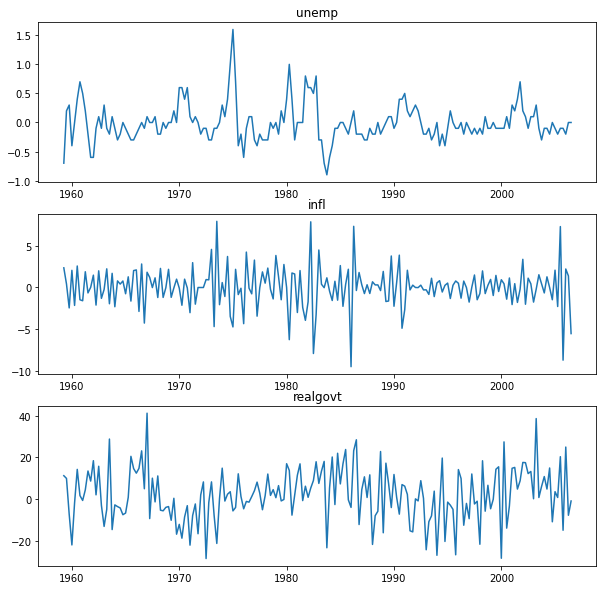

In [77]:
model.plot();

## Autocorrelation Plot

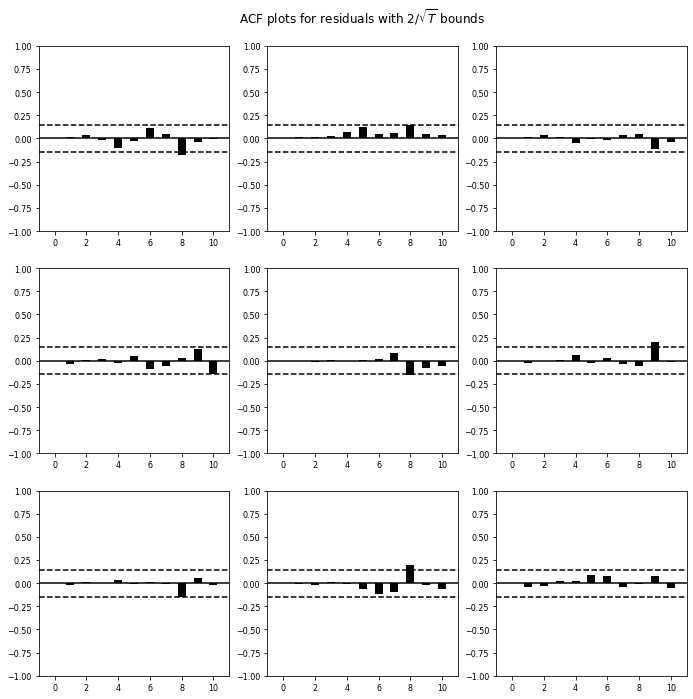

In [81]:
model.plot_acorr();

## Durbin Watson Test
* Test for autocorrelation in residuals
* If we find autocorrelated residuals, we likely have left something out of the model
* Intuition
  * Think bitcoin prices
  * If we see positive autocorrelation, then if it went up today, it goes up tomorrow
  * If we see negative autocorrelation, then if it wen down today, it goes up tomorrow
* The statistics are ranged from 0 to 4
  * A value of 2 indicates no autocorrelation
  * A value < 2 indicates positive autocorrelation
  * A value > 2 indicates negative autocorrelation
* Generally, values between 1.5 and 2.5 are typical

In [26]:
results = durbin_watson(model.resid)
for col, statistic in zip(COLUMNS, results):
  print(col, round(statistic, 3))

unemp 1.953
infl 1.97
realgovt 2.068


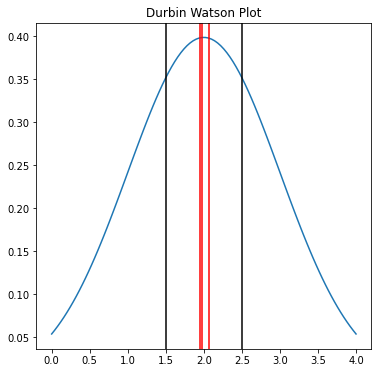

In [27]:
x = np.linspace(0, 4, 100)
plt.figure(figsize=(6,6))
plt.plot(x, stats.norm.pdf(x, 2, 1))
plt.title('Durbin Watson Plot')
for xc in results:
  plt.axvline(x=xc, color='red')
for xc in [1.5, 2.5]:
  plt.axvline(x= xc, color='black')

# Predict

## Forecast Plot

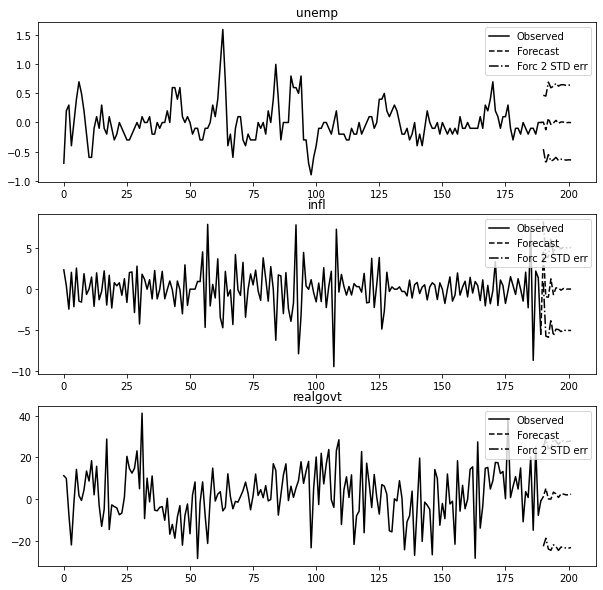

In [79]:
model.plot_forecast(12);

## Generate Predictions
* Note the scale, they're in differenced values

In [31]:
lags = model.k_ar
pred = model.forecast(y=train_df[COLUMNS].values[-lags:], steps=abs(SPLIT))
pred

array([[ 5.78849212e-03,  4.52677789e+00,  1.23584407e+00],
       [-1.25012898e-01, -9.53568192e-01,  5.16507304e+00],
       [ 7.12583408e-02, -1.00180124e+00,  1.67298721e-01],
       [-3.42188472e-02,  1.24135267e+00,  6.35602644e-02],
       [-8.65889353e-03, -6.83778806e-01,  3.38606816e+00],
       [ 3.63225121e-02,  1.38833434e-01,  2.60392743e+00],
       [-1.35250584e-02,  1.05352327e-01,  8.41011807e-01],
       [ 8.43868924e-03, -1.48185244e-01,  2.54666860e+00],
       [ 7.39234691e-03,  5.69746988e-02,  2.43873588e+00],
       [-4.93019934e-03, -2.44285160e-02,  2.09330425e+00],
       [ 7.03794987e-04, -6.29736463e-03,  2.11934897e+00],
       [-1.57766650e-03, -9.40838456e-03,  2.38872415e+00]])

## Convert to Frame
* Note the column name using the number of differences

In [32]:
forecast_df = pd.DataFrame(pred, index=test_df.index, columns=test_df.columns + '_1')
forecast_df

,unemp_1,infl_1,realgovt_1
2006-10-01,0.005788,4.526778,1.235844
2007-01-01,-0.125013,-0.953568,5.165073
2007-04-01,0.071258,-1.001801,0.167299
2007-07-01,-0.034219,1.241353,0.063560
2007-10-01,-0.008659,-0.683779,3.386068
2008-01-01,0.036323,0.138833,2.603927
2008-04-01,-0.013525,0.105352,0.841012
2008-07-01,0.008439,-0.148185,2.546669
2008-10-01,0.007392,0.056975,2.438736
2009-01-01,-0.004930,-0.024429,2.093304


## Inverse Differences
* We forecasted in differences
* Reverse to get the forecast in the actual scale

In [42]:
for col in COLUMNS:
  forecast_df[str(col) + '_forecast'] = macro_df[col].iloc[-1 + SPLIT] + forecast_df[str(col) + '_1'].cumsum()
  forecast_df[str(col) + '_actual']   = macro_df[col][SPLIT : ] 

In [43]:
forecast_df

,unemp_1,infl_1,realgovt_1,unemp_forecast,infl_forecast,realgovt_forecast,unemp_actual,infl_actual,realgovt_actual
2006-10-01,0.005788,4.526778,1.235844,4.705788,2.946778,893.237844,4.4,3.30,894.404
2007-01-01,-0.125013,-0.953568,5.165073,4.580776,1.993210,898.402917,4.5,4.58,882.766
2007-04-01,0.071258,-1.001801,0.167299,4.652034,0.991408,898.570216,4.5,2.75,898.713
2007-07-01,-0.034219,1.241353,0.063560,4.617815,2.232761,898.633776,4.7,3.45,918.983
2007-10-01,-0.008659,-0.683779,3.386068,4.609156,1.548982,902.019844,4.8,6.38,925.110
2008-01-01,0.036323,0.138833,2.603927,4.645479,1.687816,904.623772,4.9,2.82,943.372
2008-04-01,-0.013525,0.105352,0.841012,4.631954,1.793168,905.464783,5.4,8.53,961.280
2008-07-01,0.008439,-0.148185,2.546669,4.640392,1.644983,908.011452,6.0,-3.16,991.551
2008-10-01,0.007392,0.056975,2.438736,4.647785,1.701958,910.450188,6.9,-8.79,1007.273
2009-01-01,-0.004930,-0.024429,2.093304,4.642854,1.677529,912.543492,8.1,0.94,996.287


In [41]:
macro_df.join(forecast_df)[['infl_forecast', 'infl_1', 'infl']][-15:]

,infl_forecast,infl_1,infl
2006-01-01,NaN,NaN,2.60
2006-04-01,NaN,NaN,3.97
2006-07-01,NaN,NaN,-1.58
2006-10-01,8.086778,4.526778,3.30
2007-01-01,7.133210,-0.953568,4.58
2007-04-01,6.131408,-1.001801,2.75
2007-07-01,7.372761,1.241353,3.45
2007-10-01,6.688982,-0.683779,6.38
2008-01-01,6.827816,0.138833,2.82
2008-04-01,6.933168,0.105352,8.53


## Score
* Score our errors across each time series

In [67]:
results_df = pd.DataFrame(columns=['VAR-RMSE', 'ARIMA-RMSE'])
for col in COLUMNS:
  err = rmse(forecast_df[col + '_forecast'], forecast_df[col + '_actual'])
  results_df.loc[col, 'VAR-RMSE'] = round(err, 4)
results_df

,VAR-RMSE,ARIMA-RMSE
unemp,2.328,NaN
infl,4.2973,NaN
realgovt,69.0207,NaN


# Visualize
* Plot each time series & inspect

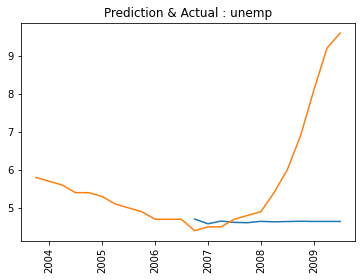

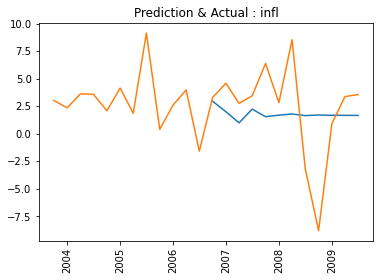

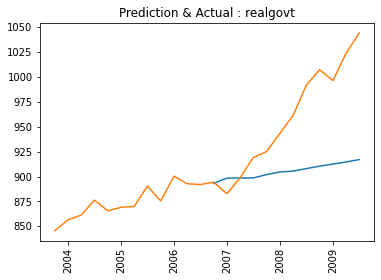

In [61]:
for col in COLUMNS:
  plt.plot()
  plt.plot(forecast_df[col + '_forecast'], label='Forecast')
  plt.plot(macro_df[col][-24:],   label='Actual')
  plt.xticks(rotation=90)
  plt.title(f'Prediction & Actual : {col}')
  plt.show()

# Compare Baselines

In [72]:
for col in COLUMNS:
  baseline = auto_arima(macro_df[col][:-12])
  pred = baseline.predict(n_periods=12)
  err = rmse(pred, forecast_df[col + '_actual'])
  results_df.loc[col, 'ARIMA-RMSE'] = round(err, 4)

  print(f'[+] ... {col}')
  print(baseline)

[+] ... unemp
 ARIMA(2,0,0)(0,0,0)[0] intercept
[+] ... infl
 ARIMA(2,1,0)(0,0,0)[0]          
[+] ... realgovt
 ARIMA(1,1,3)(0,0,0)[0]          


In [73]:
results_df

,VAR-RMSE,ARIMA-RMSE
unemp,2.328,1.7986
infl,4.2973,4.42
realgovt,69.0207,73.0325
